In [1]:
#import libraries and functions to load the data
from matplotlib import pyplot as plt

import os
import time

import numpy as np
import torch
import torch.nn.functional as F

In [2]:
#for nvidia 
has_gpu = torch.cuda.is_available()
#for mac
has_mps = getattr(torch,'has_mps',False)
device = "mps" if getattr(torch,'has_mps',False) \
    else "cuda" if torch.cuda.is_available() else "cpu"

print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

## Some Hyperparameters 
random_seed = 1
batch_size = 128
learning_rate = 0.01
num_epochs = 40
num_classes = 12

GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
Target device is mps


/var/folders/18/jb6sg5tn0wd0md220_4vpttw0000gn/T/ipykernel_2879/3840129315.py:4: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  has_mps = getattr(torch,'has_mps',False)
/var/folders/18/jb6sg5tn0wd0md220_4vpttw0000gn/T/ipykernel_2879/3840129315.py:5: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = "mps" if getattr(torch,'has_mps',False) \


In [3]:
from torchvision import transforms, datasets
from torch.utils.data.dataset import random_split
from torchvision.datasets import ImageFolder

train_data_transform = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((32, 32)),  
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ]
)
test_data_transform = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((32, 32)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ]
)

In [4]:
import torchvision.transforms as transforms
from torch.utils.data.dataset import random_split
from torchvision.datasets import FashionMNIST
import torchvision
import torch
from torch.utils.data import DataLoader, Dataset, random_split


dataset = torchvision.datasets.ImageFolder(root='kanji_dataset', transform=train_data_transform)

train_size = int(0.8 * len(dataset))  
test_size = len(dataset) - train_size  
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_size = int(0.9 * len(train_dataset))  
valid_size = len(train_dataset) - train_size  

train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])


In [5]:
from torch.utils.data import DataLoader
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    drop_last=True,
    num_workers=3,
    shuffle=True
)
valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    drop_last=False,
    num_workers=3,
    shuffle=False
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    drop_last=False,
    num_workers=3,
    shuffle=False
)

Mini_batch Dimensions: [B, C, H, W] = 
torch.Size([128, 1, 32, 32])


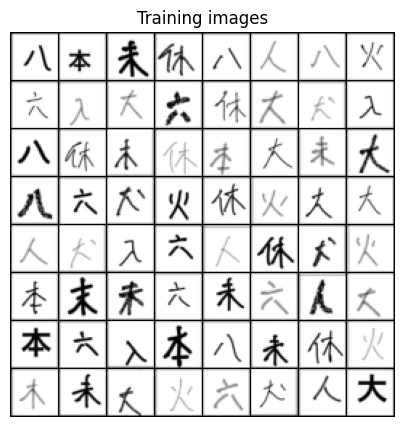

Labels = 
[[ 1  5  8 11  1  4  1  3]
 [ 9  2  0  9 11  0  6  2]
 [ 1 11  7 11  5  0  8  0]
 [ 1  9  6  3 11  3  0  0]
 [ 4  6  2  9  4 11  6  3]
 [ 5 10  8  9  8  9  4  0]
 [ 5  9  2  5  1  8 11  3]
 [ 7  8  0  3  9  6  4  0]]


In [6]:
import torchvision.utils as vutils

%matplotlib inline
import matplotlib.pyplot as plt

im_batch = next(iter(train_loader))
print('Mini_batch Dimensions: [B, C, H, W] = ')
print(im_batch[0].shape)
plt.figure(figsize=(5, 5))
plt.title("Training images")
plt.axis("off")
plt.imshow(
    np.transpose(
        vutils.make_grid(im_batch[0][:64], nrow=8, padding=1, normalize=True), (1, 2, 0)
    )
)
plt.show()
print("Labels = " )
print(im_batch[1][:64].data.numpy().reshape(8,-1))


In [9]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import time

# Load your dataset and define train_loader and test_loader

# 1. Obtain model
model = models.googlenet(pretrained=False)

# 2. Change first convolutional layer
# GoogleNetの最初の畳み込み層は、input: 3チャンネル、output: 64チャンネルです。
# 新しいモデルを定義する必要はなく、元のモデルの畳み込み層の重みを書き換えます。
weights = model.conv1.conv.weight.data
new_weights = weights[:, 0, :, :].unsqueeze(1)
model.conv1.conv.weight.data = new_weights

# 3. Change last layer
num_classes = 12  # 分類するクラスの数
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Define number of epochs
num_epochs = 30

# Training loop
for epoch in range(num_epochs):
    start_time = time.time()  # Get start time
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)  # logitsからのロスを計算
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Evaluate the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # logitsから予測値を取得
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss}, Accuracy: {accuracy}, Time: {time.time() - start_time:.2f} sec')


TypeError: cross_entropy_loss(): argument 'input' (position 1) must be Tensor, not GoogLeNetOutputs

In [ ]:
from sklearn.metrics import confusion_matrix

model = model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        logits = model(imgs)
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[29  0  0  0  0  0  0  1  0  1  0  0]
 [ 0 22  0  0  0  0  0  0  0  1  0  1]
 [ 0  0 23  0  0  0  0  0  0  0  1  0]
 [ 0  0  0 17  0  1  1  0  0  1  1  0]
 [ 4  0  1  0 25  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 24  0  1  0  0  0  0]
 [ 0  0  0  1  1  0 19  0  0  0  0  0]
 [ 0  0  0  0  0  2  0 18  2  0  2  0]
 [ 0  0  0  0  0  2  0  0 29  0  0  0]
 [ 1  2  0  0  1  0  0  0  0 16  0  0]
 [ 0  0  0  0  0  0  0  2  0  0 20  0]
 [ 0  0  0  1  0  0  0  0  0  0  0 34]]
